In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings

In [2]:
plt.style.use('ggplot')

warnings.filterwarnings('ignore')

## 1. Data Exploration

In [3]:
df = pd.read_csv('/kaggle/input/students-performance-dataset/Student_performance_data _.csv')

In [ ]:
df.head(3)

In [51]:
df.isna().sum()

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

In [52]:
df.describe()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,690.655244,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,1001.000000,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1598.750000,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,2196.500000,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,2794.250000,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,3392.000000,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


<Axes: >

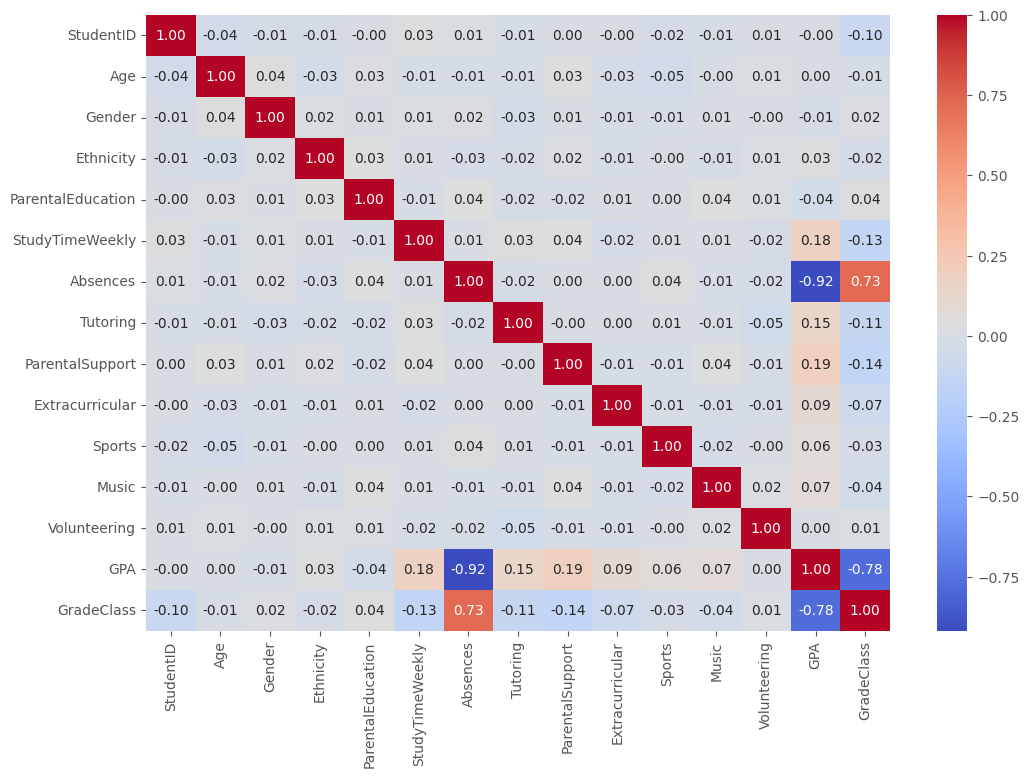

In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')

# Pytania
* Czy studenci zaangażowani w zajęcia muzyczne lub sportowe lepiej się uczą?
* Czy tutoring wpływa na średnią?
* Czy płeć lub pochodzenie wpływa na wyniki w nauce?
* Czy wykształcenie rodziców ma wpływ na wyniki dzieci?
* Czy ilość poświęcanego czasu ma wpływ na średnią?
* Czy nieobecności negatywnie odbijają się na wyniki w nauce?

In [55]:
df.query('Music == 1').GradeClass.value_counts(normalize=True)

GradeClass
4.0    0.479830
3.0    0.171975
2.0    0.154989
1.0    0.148620
0.0    0.044586
Name: proportion, dtype: float64

In [56]:
df.query('Music == 0').GradeClass.value_counts(normalize=True)

GradeClass
4.0    0.512754
3.0    0.173347
2.0    0.165539
1.0    0.103592
0.0    0.044768
Name: proportion, dtype: float64

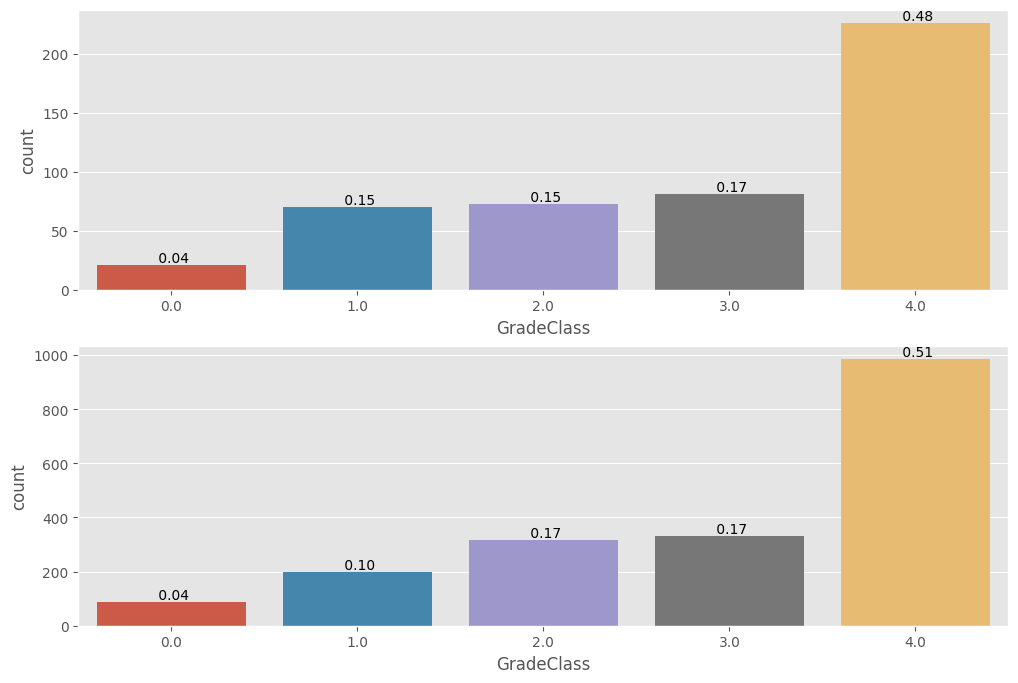

In [57]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
ax = sns.countplot(data=df.query('Music == 1'), x='GradeClass', )
count = df.query('Music == 1').shape[0]
for p in ax.patches:
    ax.annotate(f'{(p.get_height()/count): .2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')
    
plt.subplot(2, 1, 2)
ax = sns.countplot(data=df.query('Music == 0'), x='GradeClass', )
count = df.query('Music == 0').shape[0]
for p in ax.patches:
    ax.annotate(f'{(p.get_height()/count): .2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')
    
plt.show()

In [58]:
df.query('Sports == 1').GradeClass.value_counts(normalize=True)

GradeClass
4.0    0.495868
3.0    0.173554
2.0    0.151515
1.0    0.126722
0.0    0.052342
Name: proportion, dtype: float64

In [59]:
df.query('Sports == 0').GradeClass.value_counts(normalize=True)

GradeClass
4.0    0.510804
3.0    0.172869
2.0    0.168667
1.0    0.106242
0.0    0.041417
Name: proportion, dtype: float64

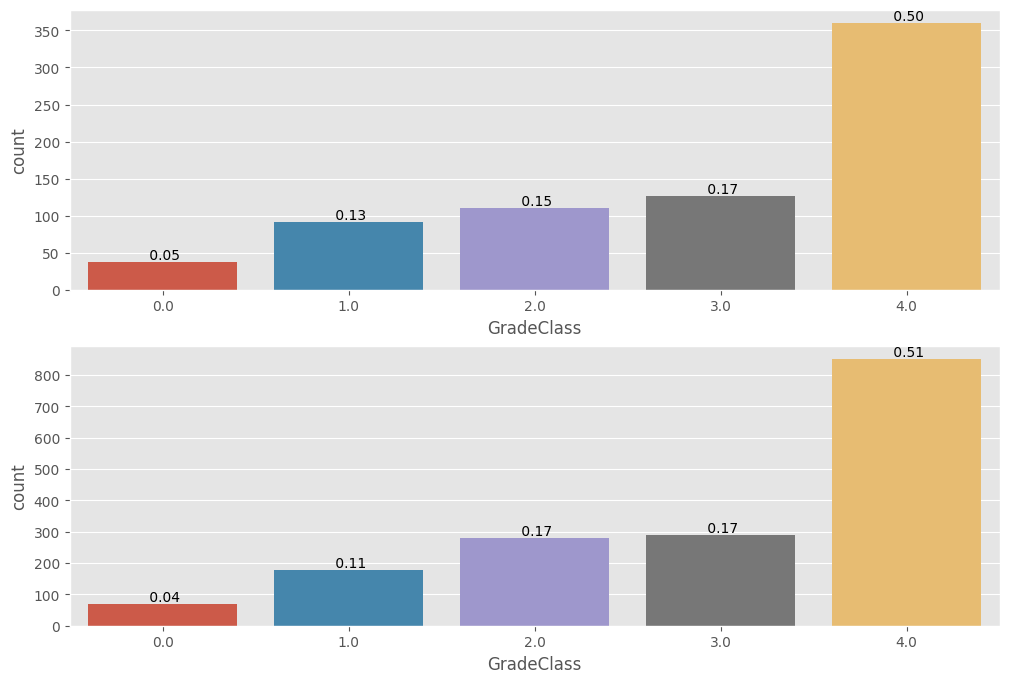

In [60]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
ax = sns.countplot(data=df.query('Sports == 1'), x='GradeClass', )
count = df.query('Sports == 1').shape[0]
for p in ax.patches:
    ax.annotate(f'{(p.get_height()/count): .2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')
    

plt.subplot(2, 1, 2)
ax = sns.countplot(data=df.query('Sports == 0'), x='GradeClass', )
count = df.query('Sports == 0').shape[0]
for p in ax.patches:
    ax.annotate(f'{(p.get_height()/count): .2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points')
    
plt.show()

Zarówno uczniowie, którzy uprawiają sport jak i ci który uczęszczają na zajęcia muzyczne otrzymują w niewielkim stopniu oceny lepsze.

In [61]:
df['Ethnicity'].value_counts()

Ethnicity
0    1207
1     493
2     470
3     222
Name: count, dtype: int64

<Axes: xlabel='Ethnicity', ylabel='GradeClass'>

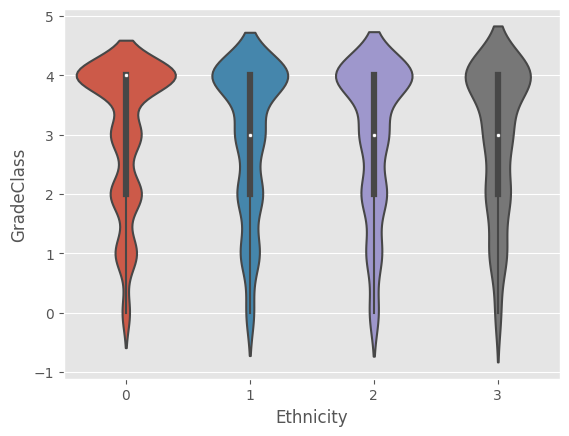

In [62]:
sns.violinplot(data=df, x='Ethnicity', y='GradeClass')

<Axes: xlabel='GradeClass', ylabel='count'>

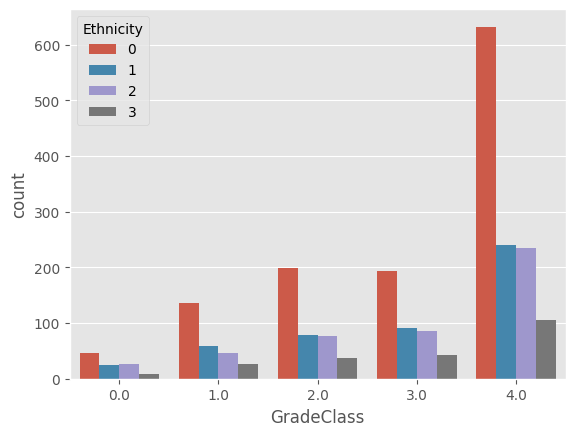

In [63]:
sns.countplot(data=df, x='GradeClass', hue='Ethnicity')

<Axes: title={'center': 'Other'}, xlabel='GradeClass', ylabel='count'>

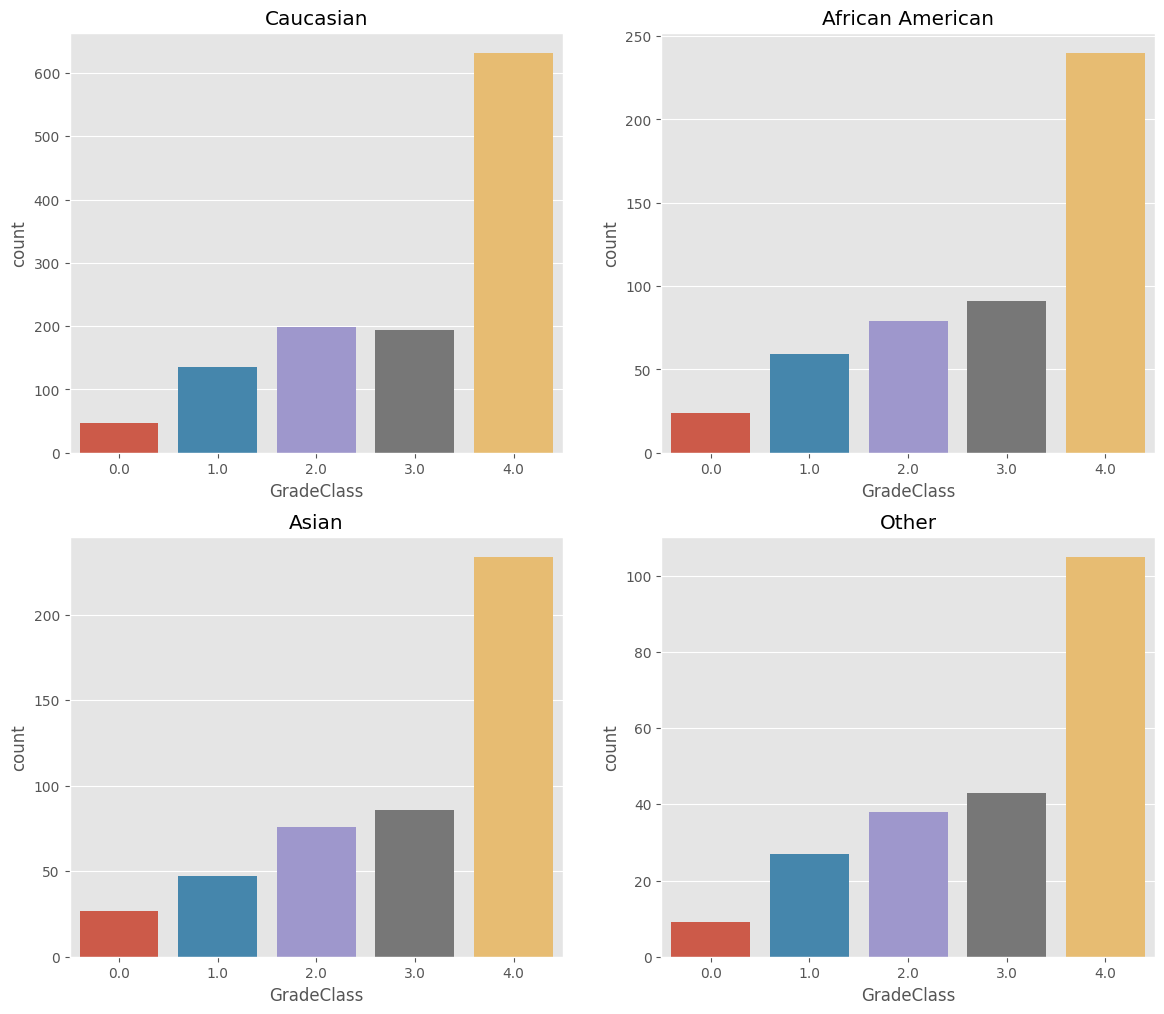

In [64]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
plt.title('Caucasian')
sns.countplot(data=df.where(df['Ethnicity'] == 0), x='GradeClass')

plt.subplot(2, 2, 2)
plt.title('African American')
sns.countplot(data=df.where(df['Ethnicity'] == 1), x='GradeClass')

plt.subplot(2, 2, 3)
plt.title('Asian')
sns.countplot(data=df.where(df['Ethnicity'] == 2), x='GradeClass')

plt.subplot(2, 2, 4)
plt.title('Other')
sns.countplot(data=df.where(df['Ethnicity'] == 3), x='GradeClass')

In [65]:
df.query('Ethnicity == 1').GradeClass.value_counts(normalize=True)

GradeClass
4.0    0.486815
3.0    0.184584
2.0    0.160243
1.0    0.119675
0.0    0.048682
Name: proportion, dtype: float64

In [66]:
df.shape[0]

2392

In [67]:
observations_count = df.shape[0]
for i in range(4):
    print(f'Ethnicity: {i}')
    print(df.where(df['Ethnicity'] == i).GradeClass.value_counts(normalize=True))
    print('--------------')

Ethnicity: 0
GradeClass
4.0    0.523612
2.0    0.164043
3.0    0.160729
1.0    0.112676
0.0    0.038940
Name: proportion, dtype: float64
--------------
Ethnicity: 1
GradeClass
4.0    0.486815
3.0    0.184584
2.0    0.160243
1.0    0.119675
0.0    0.048682
Name: proportion, dtype: float64
--------------
Ethnicity: 2
GradeClass
4.0    0.497872
3.0    0.182979
2.0    0.161702
1.0    0.100000
0.0    0.057447
Name: proportion, dtype: float64
--------------
Ethnicity: 3
GradeClass
4.0    0.472973
3.0    0.193694
2.0    0.171171
1.0    0.121622
0.0    0.040541
Name: proportion, dtype: float64
--------------


Wśród azjatów występuje największy odsetek osób otrzymujących oceną najlepszą, a wsród etniczności kaukaskiej występuje największy odsetek otrzymujących ocenę najgorszą.

In [68]:
df.query('Gender == 0').GradeClass.value_counts()

GradeClass
4.0    582
3.0    201
2.0    197
1.0    132
0.0     58
Name: count, dtype: int64

In [69]:
df.query('Gender == 1').GradeClass.value_counts()

GradeClass
4.0    629
3.0    213
2.0    194
1.0    137
0.0     49
Name: count, dtype: int64

Więcej kobiet dostaje ocenę najgorszą i mniej kobiet dostaje ocenę najlepszą.

In [70]:
df['ParentalEducation'].value_counts()

ParentalEducation
2    934
1    728
3    367
0    243
4    120
Name: count, dtype: int64

Wsród rodziców dominuje wykształcenie wyższe (College), najmniejszą grupą są osoby z wykształceniem powyżej licencjata. Większość z rodziców ukończyła jakąś uczelnie.

In [71]:
observations_count = df.shape[0]
for i in range(5):
    print(f'ParentalEducation: {i}')
    print(df.where(df['ParentalEducation'] == i).GradeClass.value_counts(normalize=True))
    print('--------------')

ParentalEducation: 0
GradeClass
4.0    0.510288
2.0    0.172840
3.0    0.160494
1.0    0.111111
0.0    0.045267
Name: proportion, dtype: float64
--------------
ParentalEducation: 1
GradeClass
4.0    0.480769
3.0    0.186813
2.0    0.174451
1.0    0.116758
0.0    0.041209
Name: proportion, dtype: float64
--------------
ParentalEducation: 2
GradeClass
4.0    0.505353
2.0    0.167024
3.0    0.160600
1.0    0.115632
0.0    0.051392
Name: proportion, dtype: float64
--------------
ParentalEducation: 3
GradeClass
4.0    0.520436
3.0    0.182561
2.0    0.144414
1.0    0.108992
0.0    0.043597
Name: proportion, dtype: float64
--------------
ParentalEducation: 4
GradeClass
4.0    0.616667
3.0    0.183333
2.0    0.108333
1.0    0.075000
0.0    0.016667
Name: proportion, dtype: float64
--------------


Co ciekawe wraz z wyższym wykształceniem rodziców, ocena końcowa studenta koreluje ujemnie (czym wyższe wykształcenie rodziców, tym niższa ocena studenta).

In [72]:
df.columns

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA',
       'GradeClass'],
      dtype='object')

In [73]:
p_corr = df.StudyTimeWeekly.corr(df.GPA)

<Axes: title={'center': 'p = 0.1792751268560882'}, xlabel='StudyTimeWeekly', ylabel='GPA'>

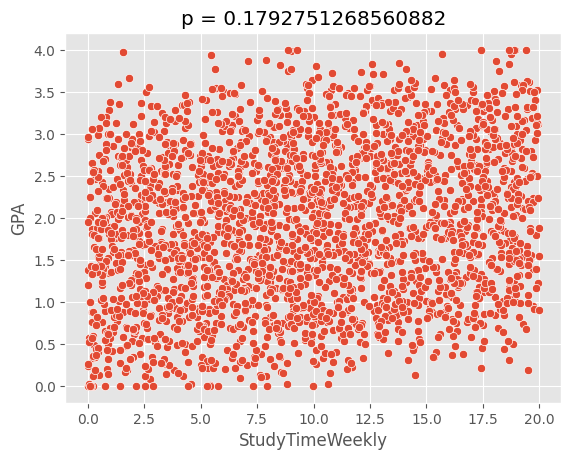

In [74]:
plt.title(f'p = {p_corr}')
sns.scatterplot(data=df, x='StudyTimeWeekly', y='GPA')

In [75]:
p_corr = df.Absences.corr(df.GPA)

<Axes: title={'center': 'p = -0.9193135764208646'}, xlabel='Absences', ylabel='GPA'>

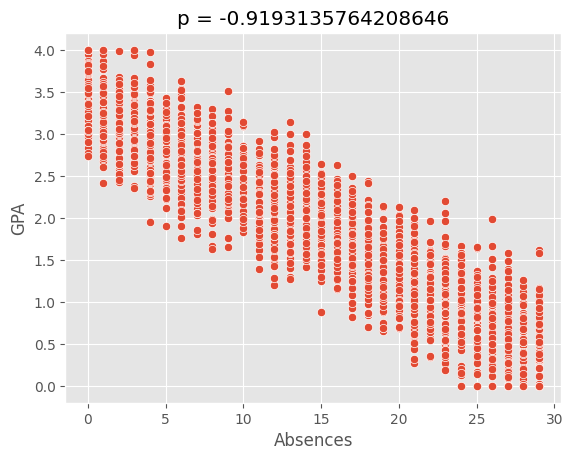

In [76]:
plt.title(f'p = {p_corr}')
sns.scatterplot(data=df, x='Absences', y='GPA')

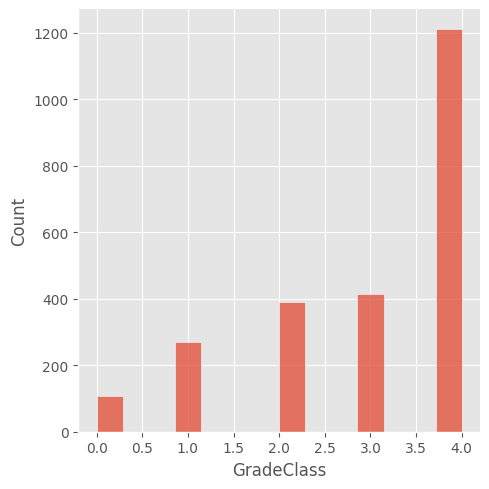

In [77]:
sns.displot(df['GradeClass'], kde=False)

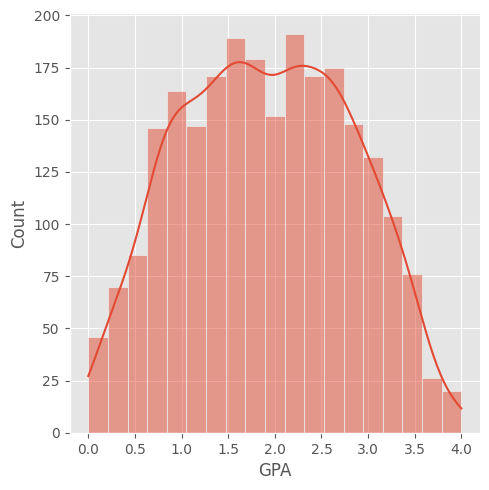

In [78]:
sns.displot(df['GPA'], kde=True)

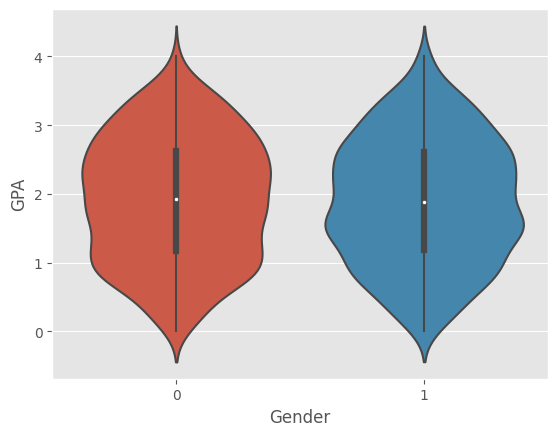

In [79]:
sns.violinplot(data=df, x='Gender', y='GPA')
plt.show()

In [80]:
df_copy = df.copy()

In [81]:
df_copy.columns

Index(['StudentID', 'Age', 'Gender', 'Ethnicity', 'ParentalEducation',
       'StudyTimeWeekly', 'Absences', 'Tutoring', 'ParentalSupport',
       'Extracurricular', 'Sports', 'Music', 'Volunteering', 'GPA',
       'GradeClass'],
      dtype='object')

In [82]:
df_copy = df_copy.drop(['StudentID', 'GradeClass'], axis=1)

In [83]:
train_df, test_df = train_test_split(df_copy, test_size=0.2, random_state=42, shuffle=False)

In [84]:
print(f'Train df shape is: {train_df.shape}.')
print(f'Test df shape is: {test_df.shape}.')

Train df shape is: (1913, 13).
Test df shape is: (479, 13).


## 2. Model

In [85]:
X_train = train_df.drop('GPA', axis=1)
y_train = train_df['GPA']

X_test = test_df.drop('GPA', axis=1)
y_test = test_df['GPA']

In [86]:
models = {
    'LR' : LinearRegression(),
    'RF' : RandomForestRegressor(),
    'CatBoost' : CatBoostRegressor(verbose=0),
    'LGBM' : LGBMRegressor()
}

for name, model in models.items():
    score = -cross_val_score(model, X=X_train, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    print(f'{name} : {score.mean()}')

LR : 0.040204061836336305
RF : 0.060231111285518724
CatBoost : 0.04526421393084411
LGBM : 0.05005209137445278


In [87]:
model = LinearRegression()

In [88]:
model.fit(X_train, y_train)

LinearRegression()

In [89]:
X_test.shape, X_train.shape

((479, 12), (1913, 12))

In [90]:
preds = model.predict(X_test)

In [91]:
y_test.reset_index(drop=True, inplace=True)

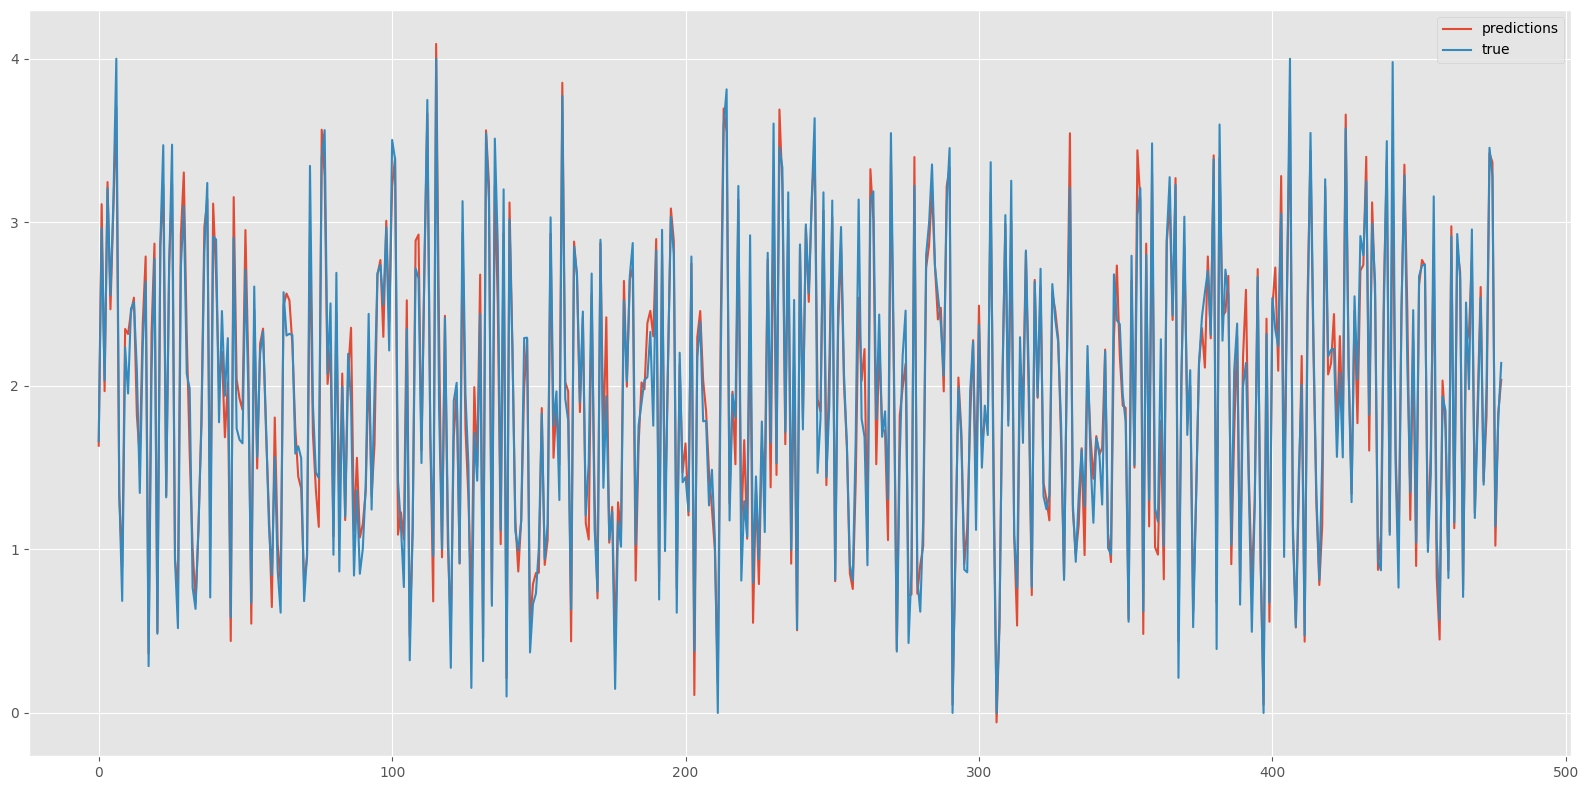

In [92]:
plt.figure(figsize=(16, 8))
plt.plot(preds, label='predictions')
plt.plot(y_test, label='true')
plt.legend()
plt.tight_layout()
plt.show()